In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from numpy import random as rd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from ito_diffusion_multi_d import *
from lasso import *

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.style.use('dark_background')

In [2]:
params = {
    'font.size': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.figsize': (11,7),
}
plt.rcParams.update(params)

In [3]:
n_epochs = int(1e4)
learning_rate = 0.005

## Generate synthetic data : 3 correlated Brownian motions

In [4]:
START_DATE = datetime(2017,1,18)
END_DATE = datetime(2019,1,14)
xl = pd.ExcelFile('yc_ust.xls')
df = pd.read_excel(xl, index_col='Date')
df = df[df.index>=START_DATE]
df = df[df.index<=END_DATE]
rets = ((df-df.shift(1))/df.shift(1)).iloc[1:]
m, n = rets.shape

In [5]:
# individual returns
data_raw = np.array(rets)
# returns of a equiweighhted portfolio
target_raw = np.array(rets).sum(axis=1).reshape(-1, 1) / n 

# use two scalers, one for data one for target
# to retain the possibility of scaling back to the original data
scaler_data = StandardScaler()
scaler_target = StandardScaler()
data = scaler_data.fit_transform(data_raw)
target = scaler_target.fit_transform(target_raw)    

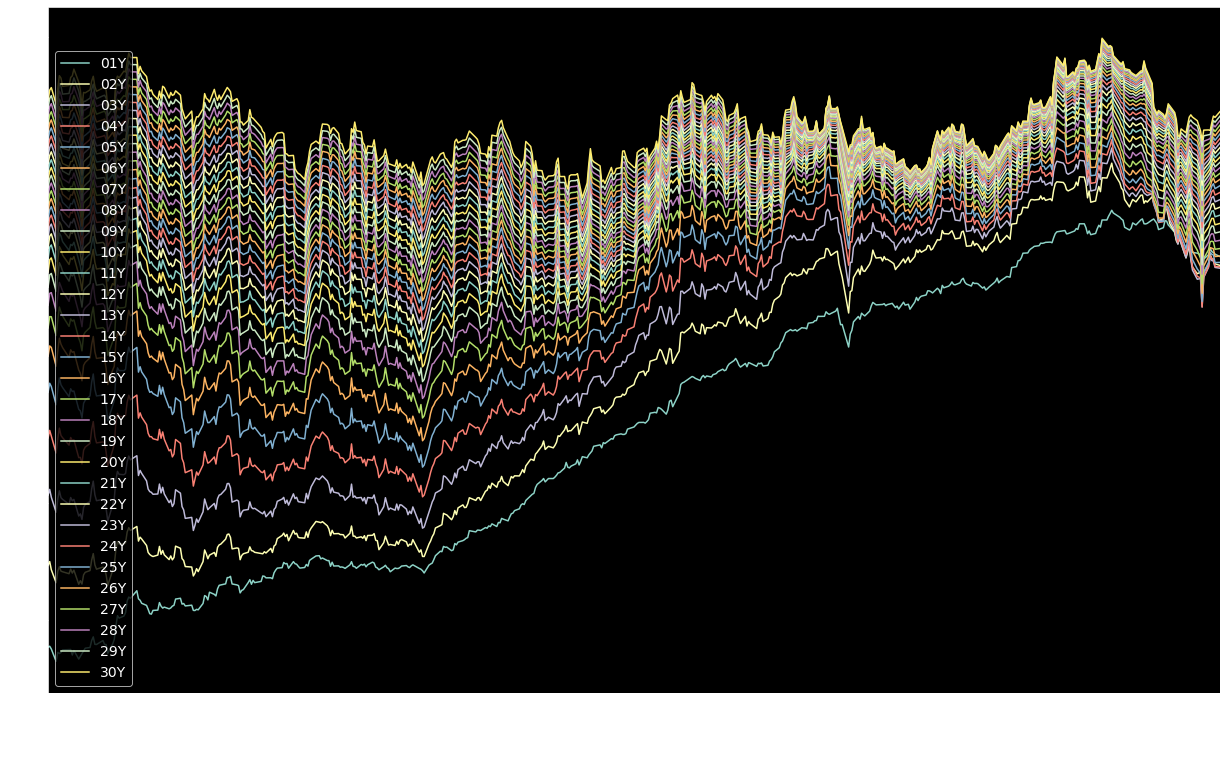

In [6]:
fig, ax = plt.subplots(figsize=(21,14), nrows=1, ncols=1)

df.plot(kind='line', ax=ax)
ax.legend(loc='lower left')

In [7]:
rets.corr().style.background_gradient()

,01Y,02Y,03Y,04Y,05Y,06Y,07Y,08Y,09Y,10Y,11Y,12Y,13Y,14Y,15Y,16Y,17Y,18Y,19Y,20Y,21Y,22Y,23Y,24Y,25Y,26Y,27Y,28Y,29Y,30Y
01Y,1,0.846349,0.780595,0.75043,0.727171,0.704855,0.682214,0.659696,0.638157,0.618042,0.599443,0.582928,0.568311,0.555315,0.54381,0.533644,0.524395,0.516107,0.50859,0.501618,0.495185,0.489086,0.483294,0.477462,0.471784,0.465907,0.45972,0.453327,0.446324,0.438666
02Y,0.846349,1,0.983862,0.957052,0.928684,0.901184,0.875037,0.850358,0.827459,0.80628,0.786911,0.769355,0.753452,0.738953,0.725614,0.713503,0.702153,0.691621,0.681762,0.672335,0.663537,0.654995,0.646748,0.638583,0.630502,0.622295,0.613797,0.604865,0.595446,0.58519
03Y,0.780595,0.983862,1,0.991998,0.97484,0.954104,0.932163,0.910223,0.889162,0.869404,0.851234,0.83475,0.819817,0.806264,0.793815,0.782542,0.772018,0.762231,0.753085,0.74429,0.736103,0.728097,0.720321,0.712615,0.704876,0.696957,0.688671,0.679818,0.67039,0.659991
04Y,0.75043,0.957052,0.991998,1,0.994815,0.982669,0.966805,0.949166,0.931146,0.913635,0.897156,0.882016,0.868184,0.855588,0.844003,0.833501,0.82373,0.814653,0.806214,0.79811,0.790612,0.783293,0.776202,0.769191,0.762111,0.754834,0.747156,0.738863,0.729922,0.719937
05Y,0.727171,0.928684,0.97484,0.994815,1,0.996246,0.986963,0.974391,0.960213,0.945623,0.931351,0.917894,0.905361,0.893793,0.883056,0.873243,0.864103,0.855603,0.847729,0.840201,0.833285,0.826584,0.82014,0.813816,0.807439,0.800885,0.793939,0.786383,0.778142,0.768833
06Y,0.704855,0.901184,0.954104,0.982669,0.996246,1,0.9971,0.989784,0.979816,0.968542,0.95684,0.945352,0.934324,0.923902,0.914066,0.90494,0.896383,0.888383,0.880975,0.873918,0.86747,0.861279,0.855382,0.849651,0.843905,0.838017,0.831771,0.824941,0.817419,0.808834
07Y,0.682214,0.875037,0.932163,0.966805,0.986963,0.9971,1,0.997715,0.991959,0.984119,0.97516,0.965818,0.956456,0.947312,0.938473,0.930099,0.922153,0.914655,0.907685,0.90105,0.895003,0.889239,0.883794,0.87855,0.873325,0.867991,0.862336,0.856127,0.849226,0.841281
08Y,0.659696,0.850358,0.910223,0.949166,0.974391,0.989784,0.997715,1,0.998214,0.993719,0.987523,0.980404,0.972814,0.965063,0.957328,0.949802,0.942541,0.935593,0.929081,0.922864,0.917186,0.911792,0.906716,0.901856,0.897034,0.89212,0.886909,0.881165,0.874728,0.867264
09Y,0.638157,0.827459,0.889162,0.931146,0.960213,0.979816,0.991959,0.998214,1,0.998608,0.995054,0.990126,0.984333,0.978038,0.971482,0.96489,0.958385,0.952049,0.946035,0.940254,0.934937,0.929879,0.925113,0.920552,0.916025,0.911404,0.90649,0.901047,0.894899,0.887735
10Y,0.618042,0.80628,0.869404,0.913635,0.945623,0.968542,0.984119,0.993719,0.998608,1,0.99889,0.996051,0.992027,0.98721,0.981884,0.976297,0.97062,0.964963,0.9595,0.954189,0.949247,0.944514,0.940022,0.935699,0.931381,0.926946,0.9222,0.916909,0.910889,0.903845


## Train wrapper

In [8]:
def train(data, 
          target,
          data_raw,
          target_raw,
          l1_strength=0.0, 
          active_features_threshold=0.01,
         ):
    model = Lasso()
    model.X = data
    model.y = target
    model.n_epochs = n_epochs
    model.verbose = False
    model.l1_strength = l1_strength
    model.optim_params = {
        'optimizer_name': 'adam',
        'learning_rate': learning_rate,
    }
    model.active_features_threshold = active_features_threshold
    
    # Train
    model.fit()
    
    # Visualize the replication portfolio weights
    model.bar_plot()
    
    # only plot some tenor
    idx = [1, 2, 5, 10, 30]
    
    # scatter regression
    fig, axes = plt.subplots(figsize=(11,14), nrows=len(idx), ncols=1)
    for i, ax in enumerate(axes):
        scaler_target = StandardScaler()
        scaler_target.fit(target_raw)
        y_fit = scaler_target.inverse_transform(np.matmul(data, model.theta_filtered))
        ax.scatter(data_raw[:, idx[i]-1], target_raw[:], marker='.', color='w', label='portfolio')
        ax.plot(data_raw[:, idx[i]-1], y_fit, '.r', alpha=0.7, label='replication')
        ax.set_xlabel('{}y yield returns'.format(idx[i]))
        ax.set_ylabel('Portfolio yield returns')
        ax.legend(loc='lower left')
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))

    plt.tight_layout()
    plt.show()

    return model

## Weak regularization


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



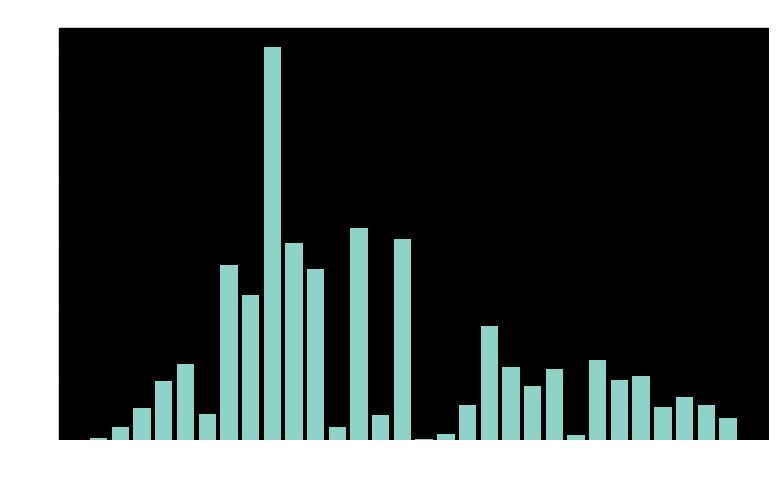

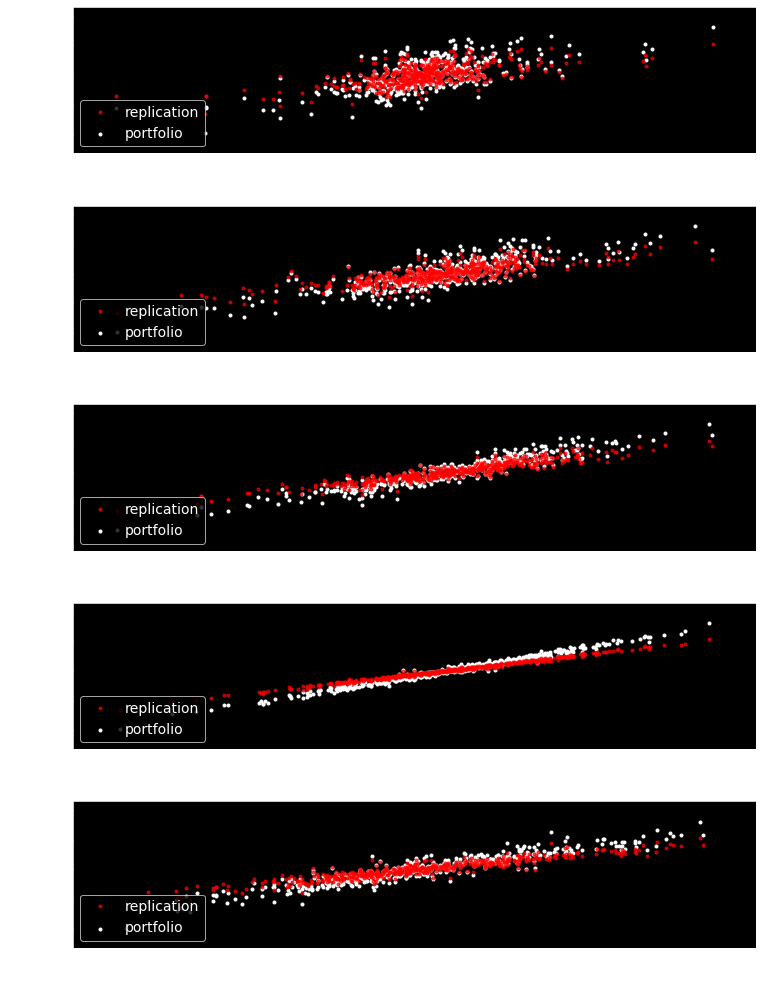

In [9]:
model = train(data, 
              target, 
              data_raw,
              target_raw,
              l1_strength=0.5, 
              active_features_threshold=0.01)

## Strong regularization

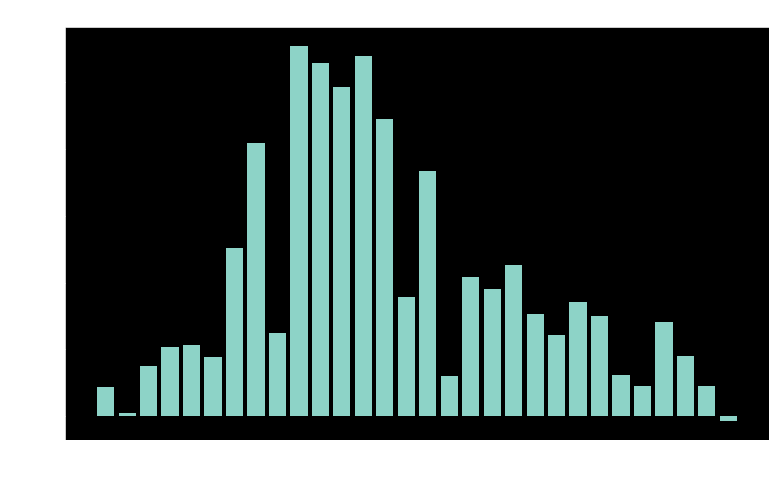

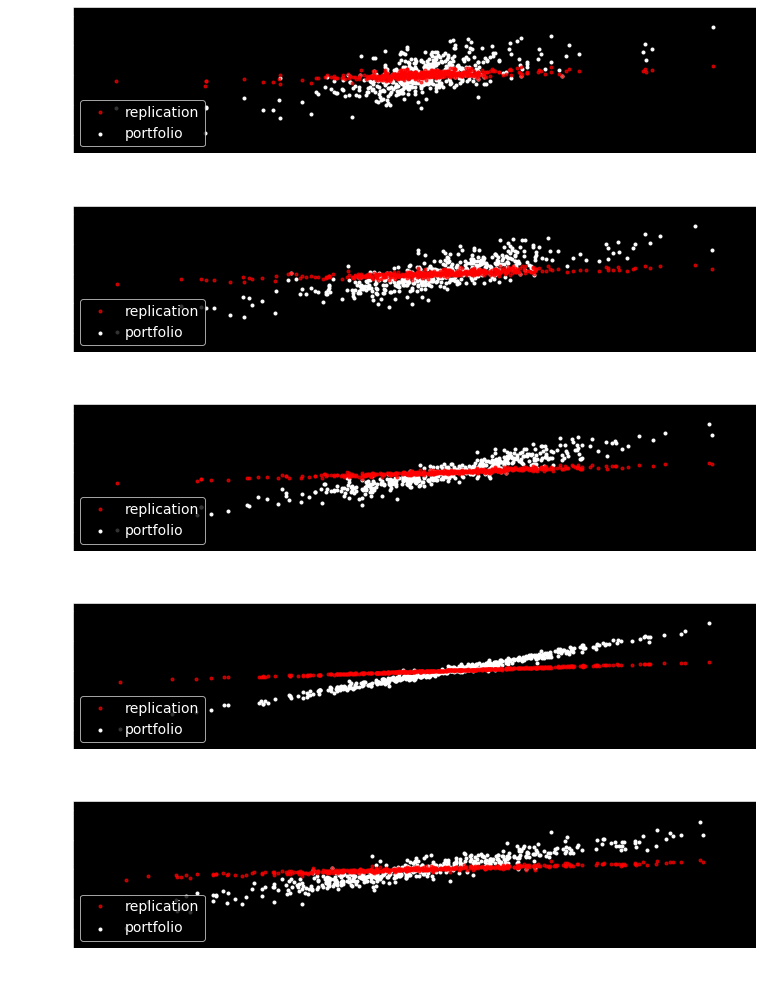

In [10]:
model = train(data, 
              target, 
              data_raw,
              target_raw,
              l1_strength=1.4, 
              active_features_threshold=0.01)

## Lasso path and number of active features

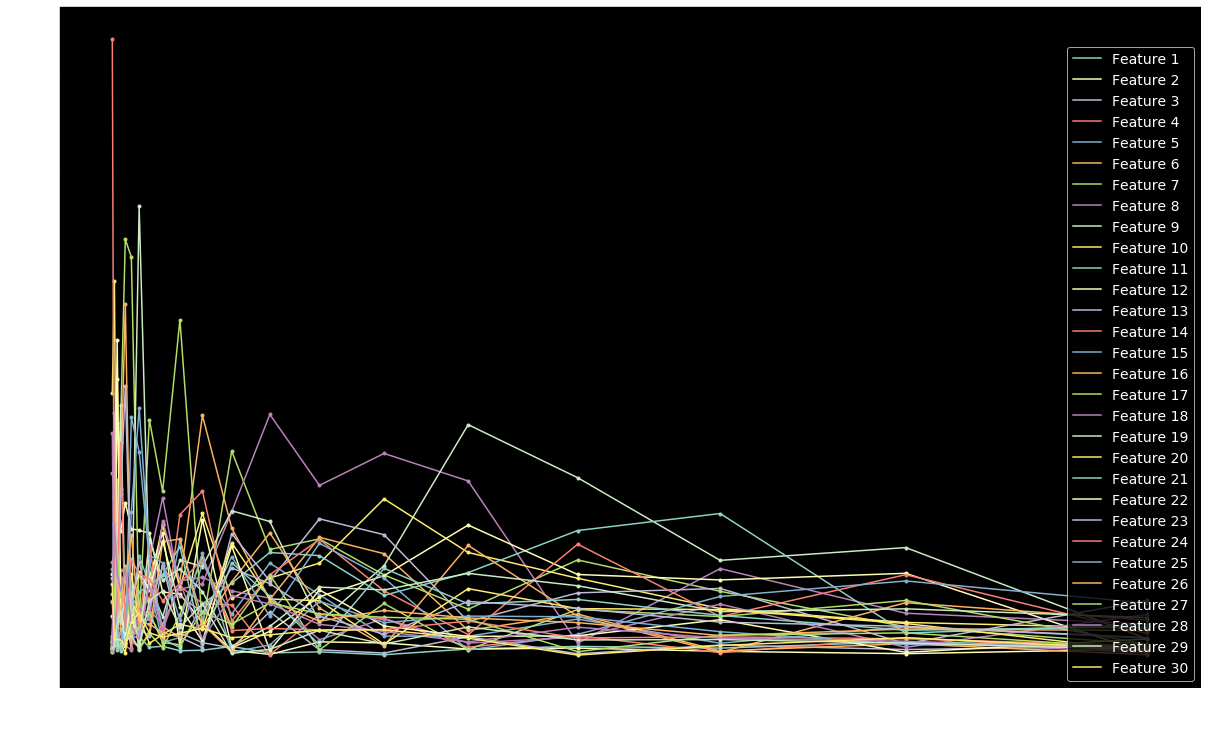

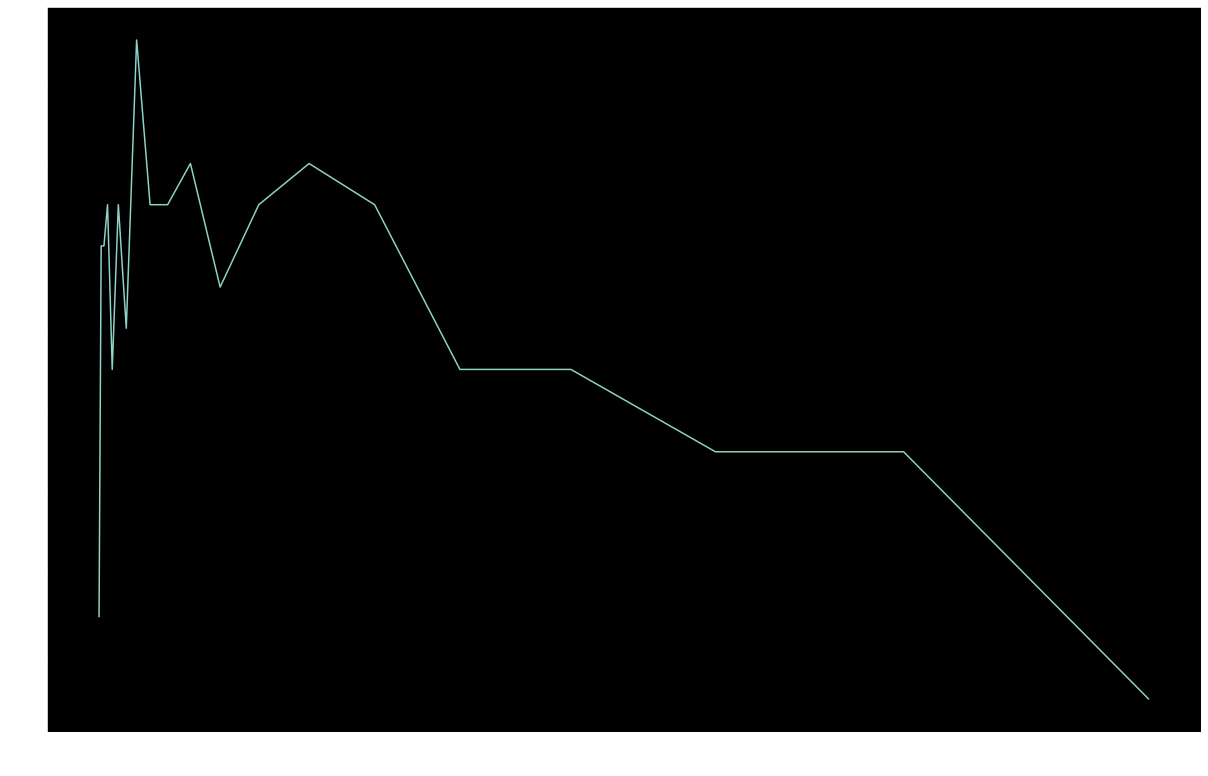

In [11]:
path, active_features_path, grid = model.lasso_path(n_l1_strength=20,
                                                    l1_min=0.01,
                                                    l1_max=1.5,
                                                    plot_path=True,
                                                    plot_active_features_path=True,
                                                   )